<a href="https://colab.research.google.com/github/psj1996-CR7/Cancer-Subtype-Classification-by-ML/blob/main/Cancer_Subtype_ML_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ucimlrepo

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz
!tar -xvf TCGA-PANCAN-HiSeq-801x20531.tar.gz
!ls TCGA-PANCAN-HiSeq-801x20531/


--2025-12-26 06:06:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘TCGA-PANCAN-HiSeq-801x20531.tar.gz’

TCGA-PANCAN-HiSeq-8     [         <=>        ]  69.48M  6.97MB/s    in 20s     

2025-12-26 06:06:48 (3.45 MB/s) - ‘TCGA-PANCAN-HiSeq-801x20531.tar.gz’ saved [72856320]



In [13]:
# 1. LOAD DATA
data_path = 'TCGA-PANCAN-HiSeq-801x20531/data.csv'
labels_path = 'TCGA-PANCAN-HiSeq-801x20531/labels.csv'
X = pd.read_csv(data_path, index_col=0)
y = pd.read_csv(labels_path, index_col=0)

In [14]:
# 2. PREPROCESSING
X_log = np.log2(X + 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

In [15]:
# 3. DIMENSIONALITY REDUCTION (PCA)
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_scaled)
var_exp = np.sum(pca.explained_variance_ratio_) * 100

In [16]:
# 4. TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
# 5. ML CLASSIFICATION (SVM)
model = SVC(kernel='linear', C=1.0, random_state=42)
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)

In [18]:
# 6. PUBLICATION QUALITY VISUALS
sns.set_context("paper", font_scale=1.2)
plt.rcParams.update({'font.family': 'sans-serif'})

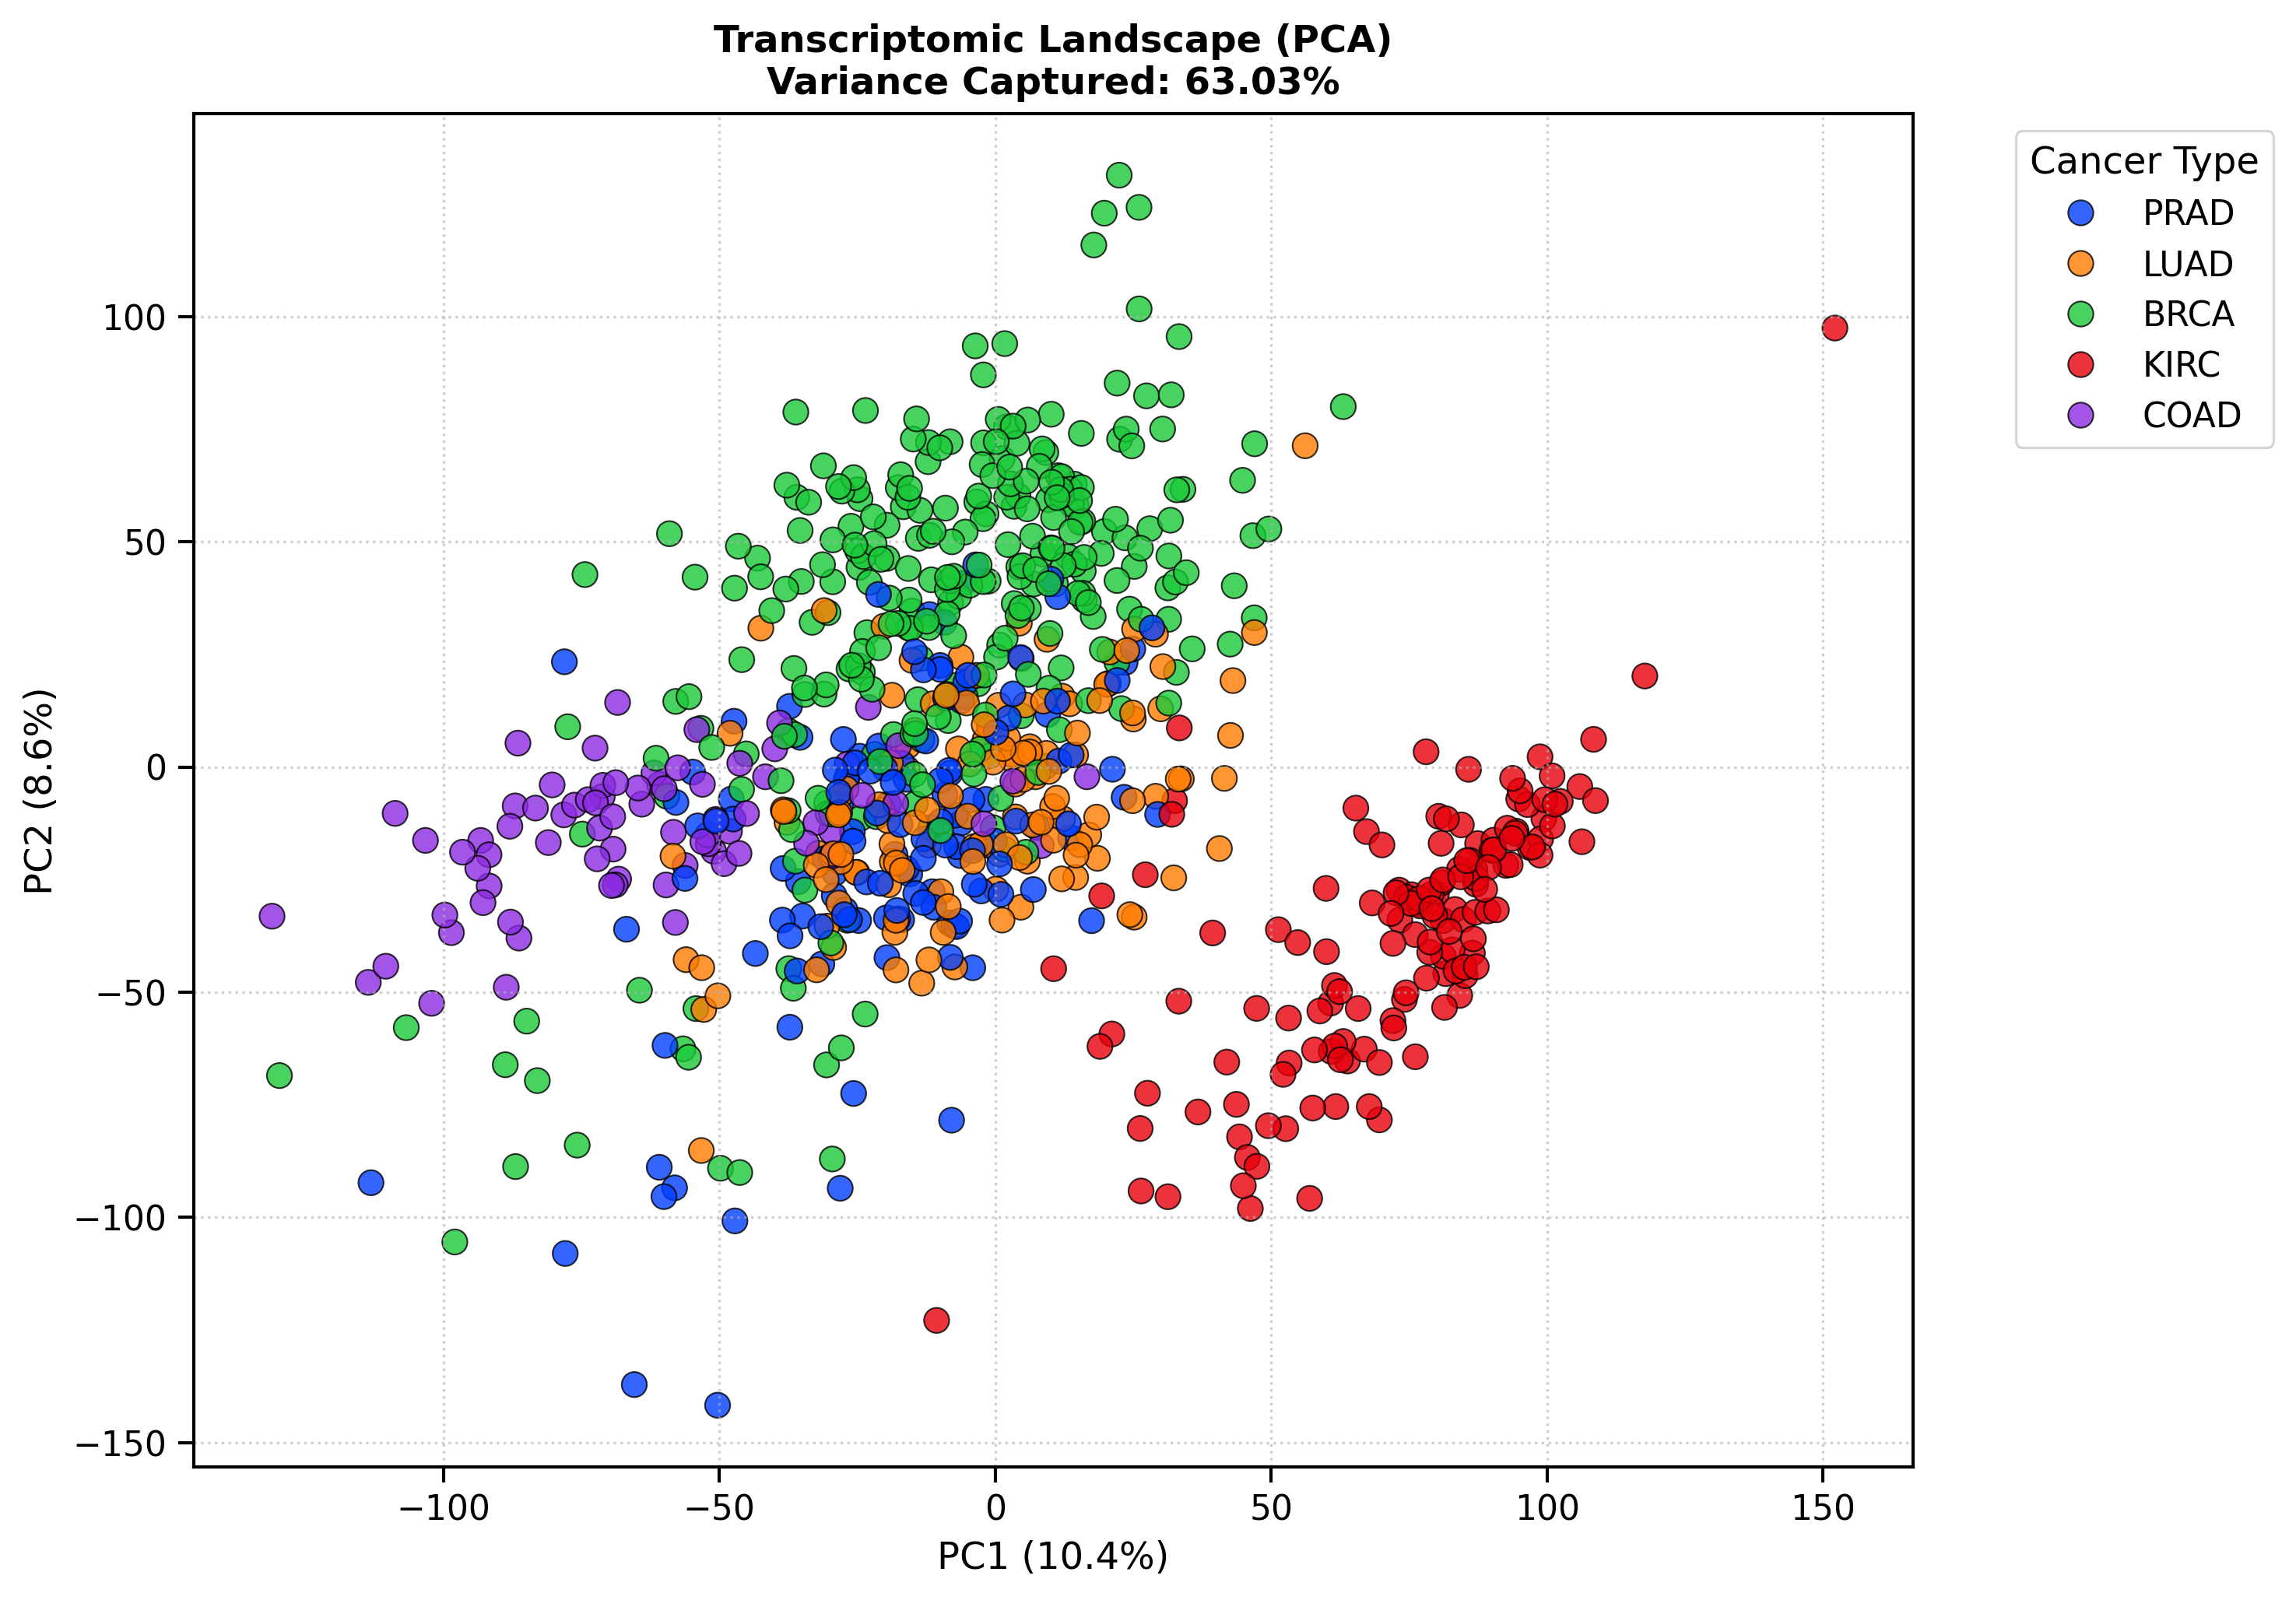

In [19]:
# Plot A: PCA Visualization

plt.figure(figsize=(10, 7), dpi=300)
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1], hue=y.values.ravel(),
    palette='bright', s=60, alpha=0.8, edgecolor='black', linewidth=0.5
)
plt.title(f"Transcriptomic Landscape (PCA)\nVariance Captured: {var_exp:.2f}%", weight='bold')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend(title="Cancer Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig('PCA_Analysis.png')
plt.show()

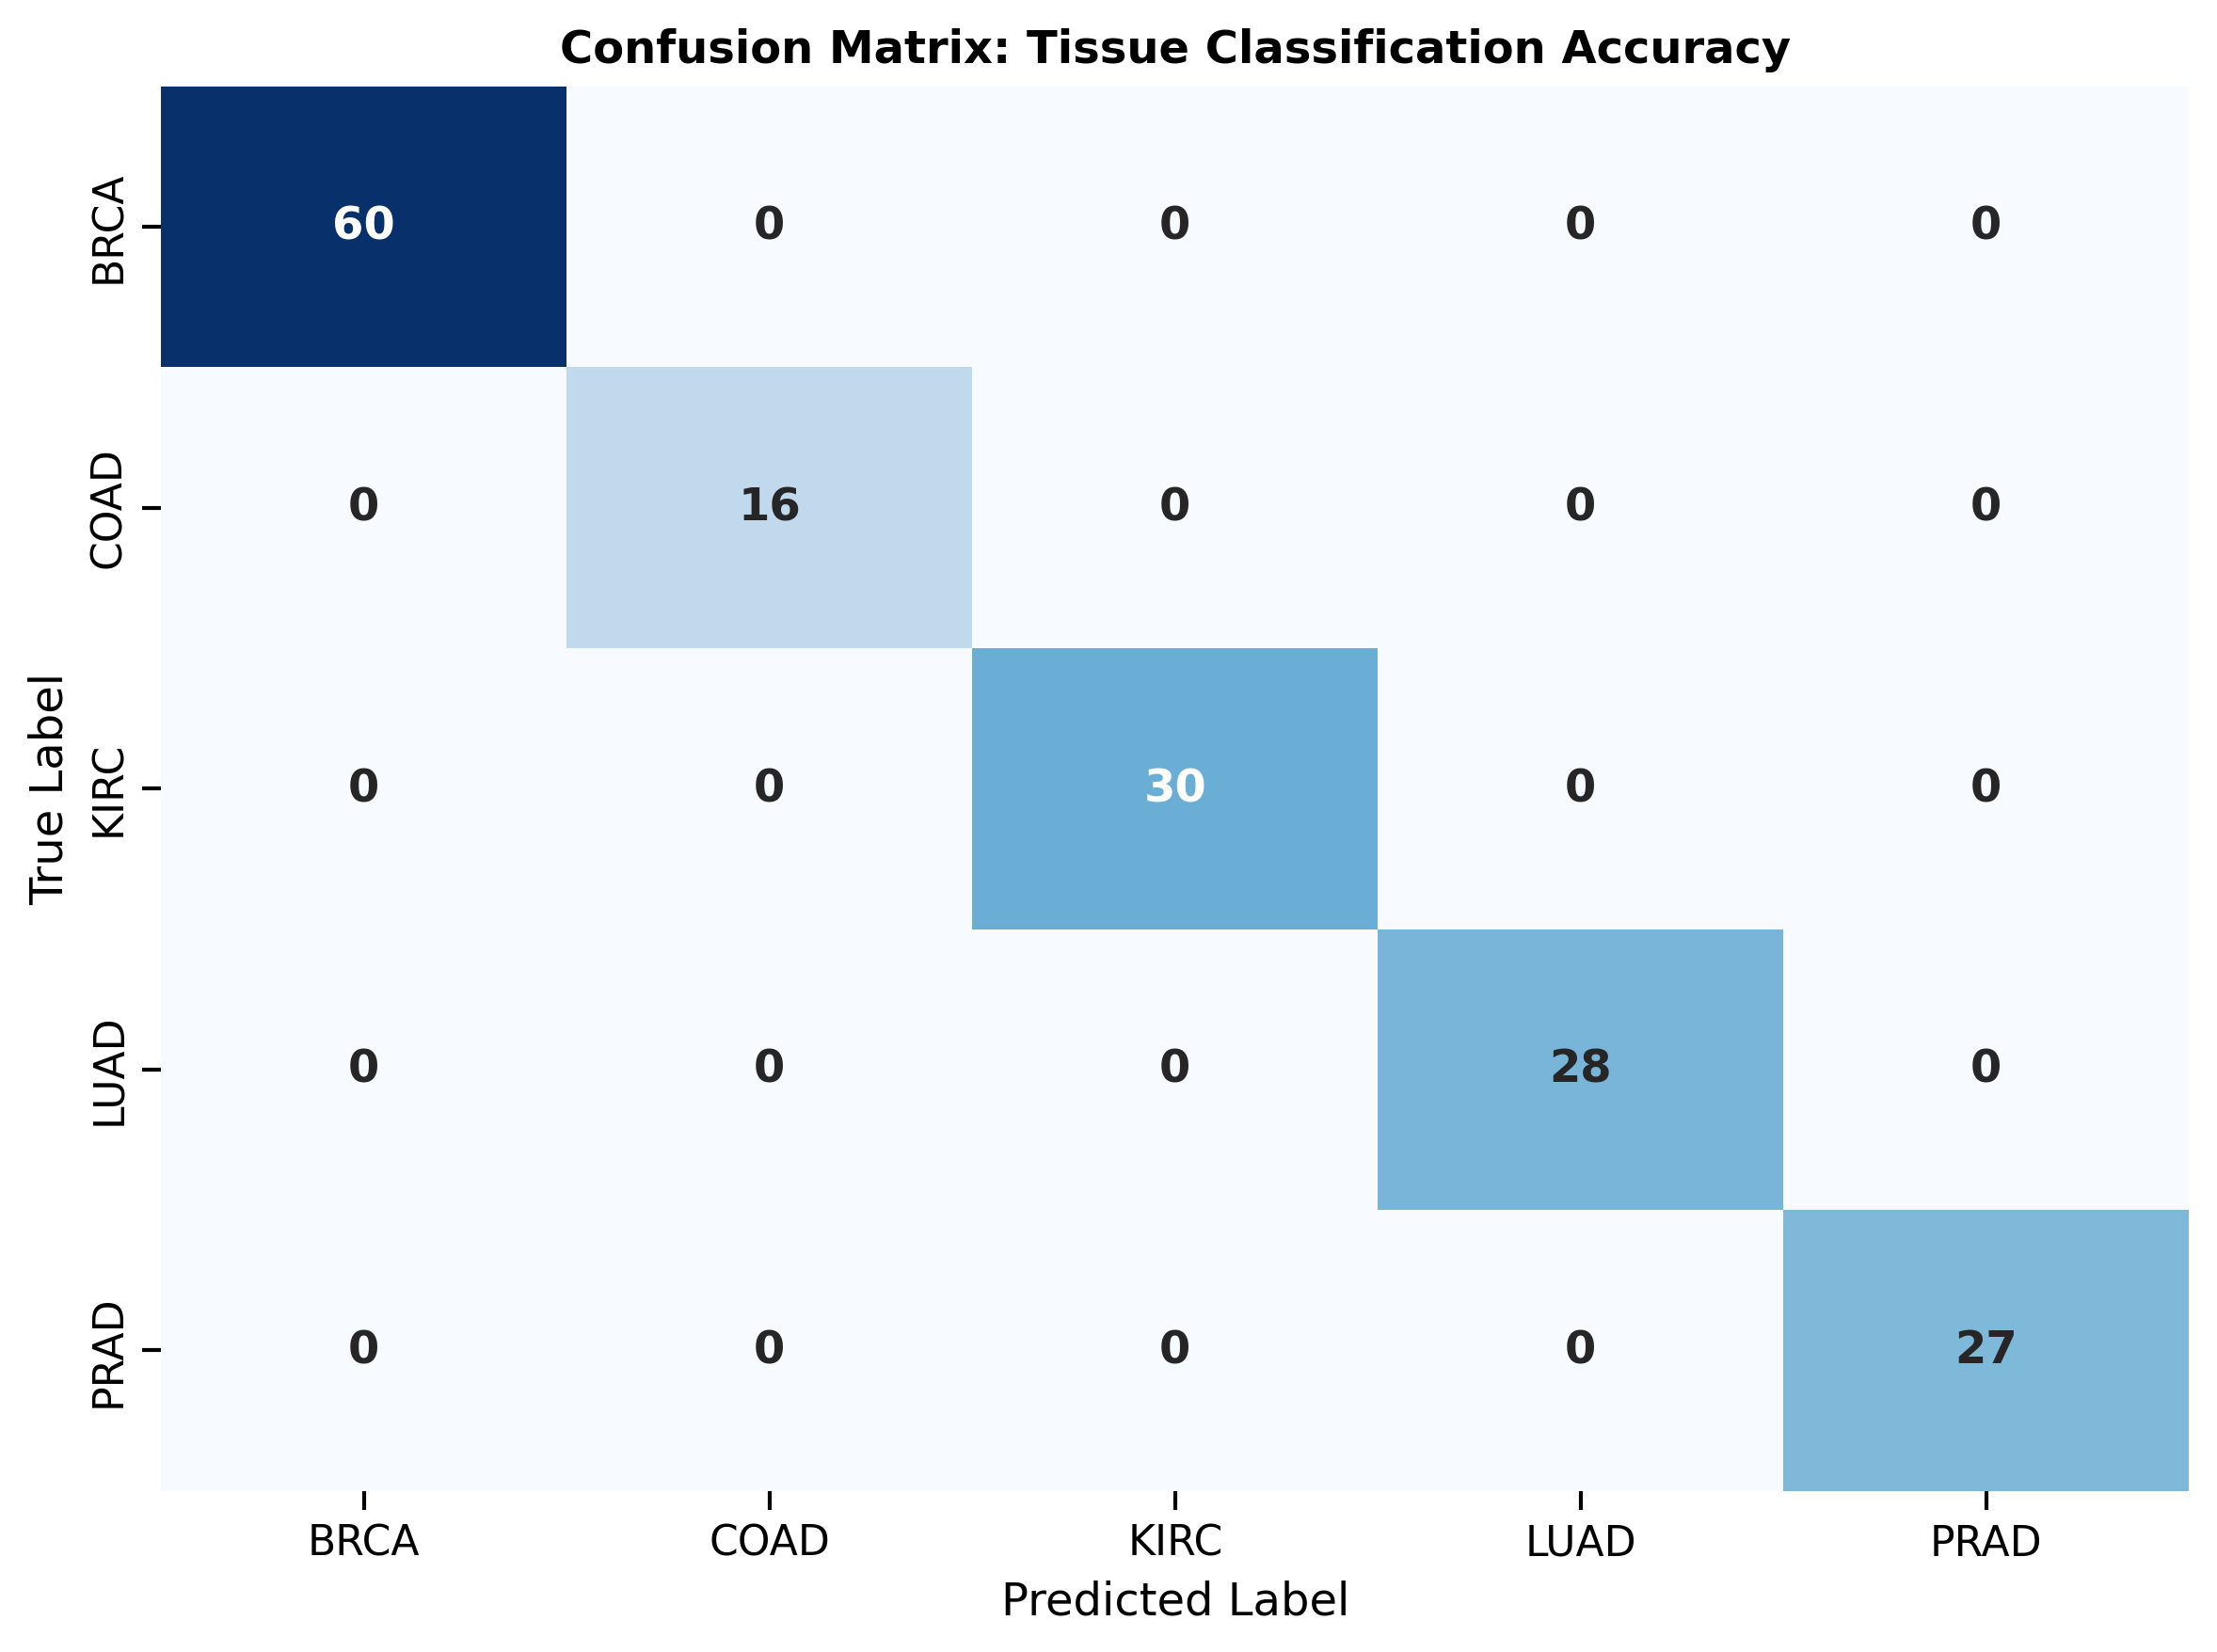

In [20]:
# Plot B: Confusion Matrix

plt.figure(figsize=(8, 6), dpi=300)
labels = np.unique(y)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=labels, yticklabels=labels, cbar=False,
    annot_kws={"weight": "bold"}
)
plt.title("Confusion Matrix: Tissue Classification Accuracy", weight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig('Confusion_Matrix.png')
plt.show()

In [21]:
# 7. RESULTS SUMMARY
print("\n" + "="*50)
print("             FINAL CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


             FINAL CLASSIFICATION REPORT
              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        60
        COAD       1.00      1.00      1.00        16
        KIRC       1.00      1.00      1.00        30
        LUAD       1.00      1.00      1.00        28
        PRAD       1.00      1.00      1.00        27

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



In [22]:
# Extract the names of the 20,531 genes
gene_names = X.columns

# Get the absolute values of the SVM coefficients
pca_components = pca.components_
svm_weights = np.abs(model.coef_)

# Calculate total importance per gene across all cancer classes
gene_importance = np.dot(svm_weights, pca_components)
avg_importance = np.mean(np.abs(gene_importance), axis=0)

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'Gene': gene_names,
    'Importance': avg_importance
}).sort_values(by='Importance', ascending=False)

# Show the Top 10 Genes
print("TOP 10 DIAGNOSTIC GENES:")
print(importance_df.head(10))

TOP 10 DIAGNOSTIC GENES:
             Gene  Importance
5237    gene_5237    0.000746
4035    gene_4035    0.000713
4397    gene_4397    0.000710
6871    gene_6871    0.000703
9387    gene_9387    0.000688
1362    gene_1362    0.000684
69        gene_69    0.000680
13714  gene_13714    0.000666
72        gene_72    0.000662
15372  gene_15372    0.000661
